In [2]:
import os
import time
from datetime import datetime

import IPython
import IPython.display

import numpy as np
from math import *

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import random 

# Tensorflow

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

2022-11-21 12:11:52.269350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib


True

2022-11-21 12:11:52.269388: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-21 12:11:52.269422: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hydra
2022-11-21 12:11:52.269444: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hydra
2022-11-21 12:11:52.269529: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-11-21 12:11:52.269575: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.56.6


# Case 

In [4]:
folders = ['Rough','UTS','Elon']
index = 0
CASE = folders[index]

In [5]:
from prepross import importAndProcess
xtrain,xval,xtest,ytrain,yval,ytest = importAndProcess(index)
x = pd.concat((xtrain,xtest,xval),axis=0)
y = pd.concat((ytrain,ytest,yval),axis=0)

# Network

In [6]:
# Hyperparameters
lossfn = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanAbsolutePercentageError(),tf.keras.losses.MeanAbsoluteError()]
lossfn = lossfn[0]
optimizer = [tf.keras.optimizers.Adam(learning_rate=i,beta_1=0.09,beta_2=0.9) for i in [5e-2,1e-2,5e-3]]
optimizer = optimizer[index]
metrics = ['mean_squared_error','mean_absolute_error',tf.keras.losses.MeanAbsolutePercentageError()]

In [7]:
modelArchitecture = [[4,'tanh',1],[5,'relu',1],[1,'linear',1]]
# modelArchitecture = [[6,'tanh',1],[4,'sigmoid',1],[3,'sigmoid',1],[1,'linear',1]]

In [8]:
#Give a random seed
tf.random.set_seed(random.randint(1,1000))
from networks import create_model

In [9]:
# Create a basic model Architecture
modelName = ''
for u,fn,b in modelArchitecture:
    modelName += str(u)+fn+str(b)+'_'
# Create Model
model = create_model(modelArchitecture,modelName,len(xtrain.columns))
# Display the model's architecture
model.summary()
model.compile(optimizer=optimizer,
                loss=lossfn, #tf.keras.losses.MSE
                metrics=metrics) #tf.keras.losses.Huber()


Model: "6tanh1_4sigmoid1_3sigmoid1_1linear1_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 48        
                                                                 
 dense_1 (Dense)             (None, 4)                 28        
                                                                 
 dense_2 (Dense)             (None, 3)                 15        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 95
Trainable params: 95
Non-trainable params: 0
_________________________________________________________________


2022-11-21 12:11:53.870935: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=100,
                                                    mode='min')
checkpoint = ModelCheckpoint(CASE+'/' + CASE + 'model.h5', monitor='val_loss', verbose=0,
                                save_best_only=True, mode='min', save_weights_only=False)
callbacks = [early_stopping,checkpoint]

history = model.fit(xtrain,ytrain,verbose=0,epochs=3500,
                    validation_data=(xval,yval),
                    batch_size = 3,
                    callbacks=callbacks)  # ,tensorboard,checkpoint]))

val_performance = model.evaluate(xval,yval)
performance = model.evaluate(xtest,ytest, verbose=0)
# print(val_performance[modelName])
# print(performance[modelName])

1/1 [==============================] - 0s 20ms/step - loss: 0.1605 - mean_squared_error: 0.1605 - mean_absolute_error: 0.3198 - mean_absolute_percentage_error: 24.4303


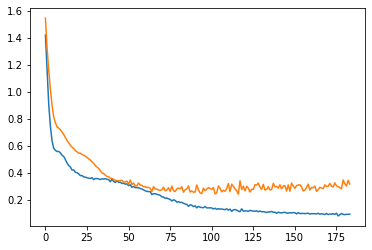

In [11]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
# plt.yscale('log')

1/1 [==============================] - 0s 20ms/step


Text(0, 0.5, 'Elon Prediction')

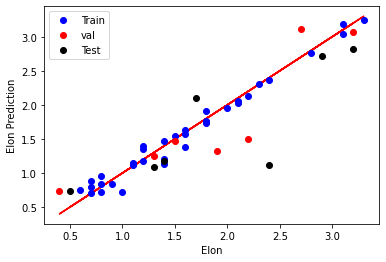

In [12]:
ypredtr =  model.predict(xtrain).squeeze()
ypredts = model.predict(xtest).squeeze()
ypredvl = model.predict(xval).squeeze()

y = [*ytrain,*ytest,*yval]
plt.plot(y,y,'r')
plt.plot(ytrain,ypredtr,'bo',label="Train")
plt.plot(yval,ypredvl,'ro',label="val")
plt.plot(ytest,ypredts,'ko',label = 'Test')
plt.legend()
plt.xlabel(CASE)
plt.ylabel(CASE +' Prediction')

In [13]:
print('Performance on validation Dataset:')
model.evaluate(xval,yval)
print('Performance on Test dataset:')
model.evaluate(xtest,ytest)
print('Performance on Train Dataset:')
model.evaluate(xtrain,ytrain)

Performance on validation Dataset:
1/1 [==============================] - 0s 20ms/step - loss: 0.1605 - mean_squared_error: 0.1605 - mean_absolute_error: 0.3198 - mean_absolute_percentage_error: 24.4303
Performance on Test dataset:
1/1 [==============================] - 0s 21ms/step - loss: 0.3026 - mean_squared_error: 0.3026 - mean_absolute_error: 0.4143 - mean_absolute_percentage_error: 24.6752
Performance on Train Dataset:
2/2 [==============================] - 0s 2ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0854 - mean_absolute_percentage_error: 4.9236


[0.012531880289316177,
 0.012531880289316177,
 0.08535352349281311,
 4.923623085021973]